
# 主題：新聞文本NLP處理與真假新聞分類
#### 第十三組 第三次讀書會專案
組員：
N124020001 林坤郁
N124020004 陳忠泰
N124020005 陳莘惠
N124020006 張祐倫
N124020012 郭展州

<h2>一、資料簡介與目標</h2>
<h3>1.1資料簡介</h3>
資料來源Kaggle:https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

本專案使用的資料集為 Fake and Real News Dataset，由 Kaggle 提供，原始資料包含兩個檔案：
<ol>
<li>Fake.csv：包含假新聞（Fake News）之標題與內文</li>
<li>True.csv：包含真新聞（Real News）之標題與內文</li>
</ol>
每筆資料具有以下欄位：
<ol>
<li>title：新聞標題</li>
<li>text：新聞文字內容</li>
<li>subject：主題類別，如政治、世界新聞等</li>
<li>date：新聞發布時間</li>
</ol>

在資料前處理階段，我們將兩份資料加上標籤（label），其中：
假新聞（Fake）標記為 0;真新聞（True）標記為 1
並合併成一份可供分類任務使用的整合資料集。

<h3>1.2目標</h3>
本次專案主要任務為：
<ol>
<li>觀察資料特別與分布</li>
<li>利用新聞文本內容來辨識新聞真偽（即真假新聞分類任務）
這是一個典型的二元分類問題（Binary Classification），我們將嘗試透過不同的文本表示方式（Text Embedding），來建立分類模型，判斷一篇新聞是「真」還是「假」</li>
</ol>

<h3>二、引用套件與資料處理</h3>

<h4>2.1載入套件</h4>

In [2]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util, models

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px
from nltk.corpus import stopwords
import nltk
nltk.download('punkt','stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


<h4>2.2資料處理</h4>

In [3]:
#讀檔
trueNews = pd.read_csv('./raw_data/true.csv')
fakeNews = pd.read_csv('./raw_data/fake.csv')
#新增新聞類別欄位
trueNews["label"] = 1
fakeNews["label"] = 0
#合併兩份檔案
df = pd.concat([trueNews,fakeNews],axis = 0 ).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


把文章的title+text合併成為content欄位，做後續探索

In [4]:
df["content"] = df["title"].astype(str) + " : " + df["text"].astype(str)
df.head()


,title,text,subject,date,label,content
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


移除移除標點符號、數字、小寫化等基本清理

In [5]:
def clean_text(text):
    text = text.lower()                          # 小寫化
    text = re.sub(r'\d+', '', text)              # 移除數字
    text = re.sub(r'[^\w\s]', '', text)          # 移除標點符號
    text = re.sub(r'\s+', ' ', text).strip()     # 移除多餘空白
    return text

df["content_clean"] = df["content"].apply(clean_text)


使用 NLTK 進行英文斷詞（tokenization）

In [6]:
df["tokens"] = df["content_clean"].apply(word_tokenize)


去除停用詞（stopwords）與詞幹還原（stemming）

In [7]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_tokens(tokens):
    return [
        stemmer.stem(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 1
    ]

df["tokens_clean"] = df["tokens"].apply(preprocess_tokens)


<h2>三、word2vec</h2>


<h3>3.1依照資料訓練自己的模型</h3>

In [8]:
# 用tokens_clean 當input
sentences = df["tokens_clean"].tolist()

# 建bigram模型
bigram = Phrases(sentences, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

# 用bigram 模型，把threshold以上的詞合併
df["tokens_bigram"] = df["tokens_clean"].apply(lambda x: bigram_phraser[x])

In [9]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 12


In [10]:
# 只保tokens_bigram欄位的資料
sentences = df["tokens_bigram"].tolist()

# 8:2切資料
sentences_train, sentences_test = train_test_split(sentences, test_size=0.2, random_state=42)

# 訓練 Word2Vec 模型
w2v_model = Word2Vec(
    sentences = sentences_train,    # 使用訓練語料
    vector_size = 128,              # vector 的維度
    alpha = 0.0005, #learning rate
    window = 2,                    # 上下文視窗大小
    min_count = 30,                  # 忽略出現次數少於30次的詞
    workers= cores-2,                  # CPU core
    sg = 1,                         # 1 = skip-gram, 0 = CBOW
    epochs = 30,
    hs = 1,
    seed = 8888
)

# 訓練模型
w2v_model.train(sentences_train, total_examples=len(sentences_train), epochs=10)

# 儲存模型
w2v_model.save("w2v_fake_news.model")

查看結果

In [11]:
# 檢查最相關的字 (cosine similarity)
w2v_model.wv.most_similar('trump',topn=10)

[('presid_trump', 0.7401490211486816),
 ('trump_campaign', 0.6884645819664001),
 ('trump_administr', 0.6436774134635925),
 ('mr_trump', 0.634978711605072),
 ('penc', 0.6304383873939514),
 ('trump_tweet', 0.6278393864631653),
 ('republican_presidenti', 0.6213387250900269),
 ('donald', 0.6159462928771973),
 ('cruz', 0.6133966445922852),
 ('trump_repeatedli', 0.610881507396698)]

In [12]:
w2v_model.wv.most_similar('trump','biden',topn=10)

[('donald_trump', 0.2550921142101288),
 ('trump_campaign', 0.2277965545654297),
 ('trump_administr', 0.1802513152360916),
 ('presid_trump', 0.1454622596502304),
 ('republican_presidenti', 0.11259660124778748),
 ('wall', 0.1060466319322586),
 ('russia', 0.100100077688694),
 ('us_border', 0.09542868286371231),
 ('presid_donald', 0.09278853237628937),
 ('north_korea', 0.09228293597698212)]

跟兩個字最不相關

In [13]:
w2v_model.wv.most_similar(negative=['trump','biden'],topn=10)

[('page_get', -0.039147306233644485),
 ('feder', -0.04502130299806595),
 ('visit_donat', -0.05912575125694275),
 ('share_program', -0.06045357882976532),
 ('jay_dyer', -0.06836015731096268),
 ('boiler_room', -0.0689460039138794),
 ('subscrib_becom', -0.06940289586782455),
 ('js_dcreateel', -0.07051841169595718),
 ('polict_correct', -0.0706576406955719),
 ('jsid_id', -0.07112045586109161)]

In [14]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("china","america")

0.34232226

In [15]:
w2v_model.wv.similarity("china","taiwan")

0.8148909

In [16]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [17]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [18]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [19]:
getVecs(w2v_model,['taiwan','china'])

array([[-2.35528186e-01, -1.92918703e-01,  2.36896321e-01,
        -4.02965128e-01,  1.05421185e-01, -6.27156943e-02,
        -1.83662474e-01, -2.13295296e-01,  1.70007825e-01,
        -1.39399022e-01, -3.89173552e-02, -4.92027402e-02,
        -5.56321777e-02, -8.15680996e-02, -1.73742130e-01,
        -3.03525567e-01, -1.31195650e-01,  1.17860891e-01,
        -4.41057980e-01, -3.99969518e-02,  3.99468899e-01,
        -4.20409918e-01, -1.19618624e-01, -2.36566201e-01,
         4.29418623e-01,  1.20022364e-01, -5.19244194e-01,
        -3.50046724e-01,  2.41329655e-01, -6.46147504e-02,
        -1.76676944e-01,  6.42147958e-02, -2.40992099e-01,
         2.13083252e-01,  3.14862132e-01,  3.61641310e-02,
         4.05068159e-01, -1.19816035e-01,  9.10603404e-02,
         1.18426591e-01,  5.52126989e-02, -6.91825151e-02,
        -2.14996830e-01, -1.61233261e-01, -1.84188411e-01,
        -9.77829695e-02,  2.51325130e-01,  1.79552183e-01,
         6.43215328e-02, -7.27361083e-01,  8.13509002e-0

In [20]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))

In [21]:
expandPosWord(w2v_model,['china','taiwan'],top_n = 10)

['venezuela',
 'japan',
 'south_korea',
 'vietnam',
 'korean_peninsula',
 'beij',
 'xi',
 'us_alli',
 'diplomat_said',
 'tension',
 'india',
 'intern_commun',
 'pyongyang',
 'two_countri',
 'taiwan']

In [22]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [23]:
sample_words = np.random.choice(list(words),150,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(150, 128)
(150, 2)


In [24]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

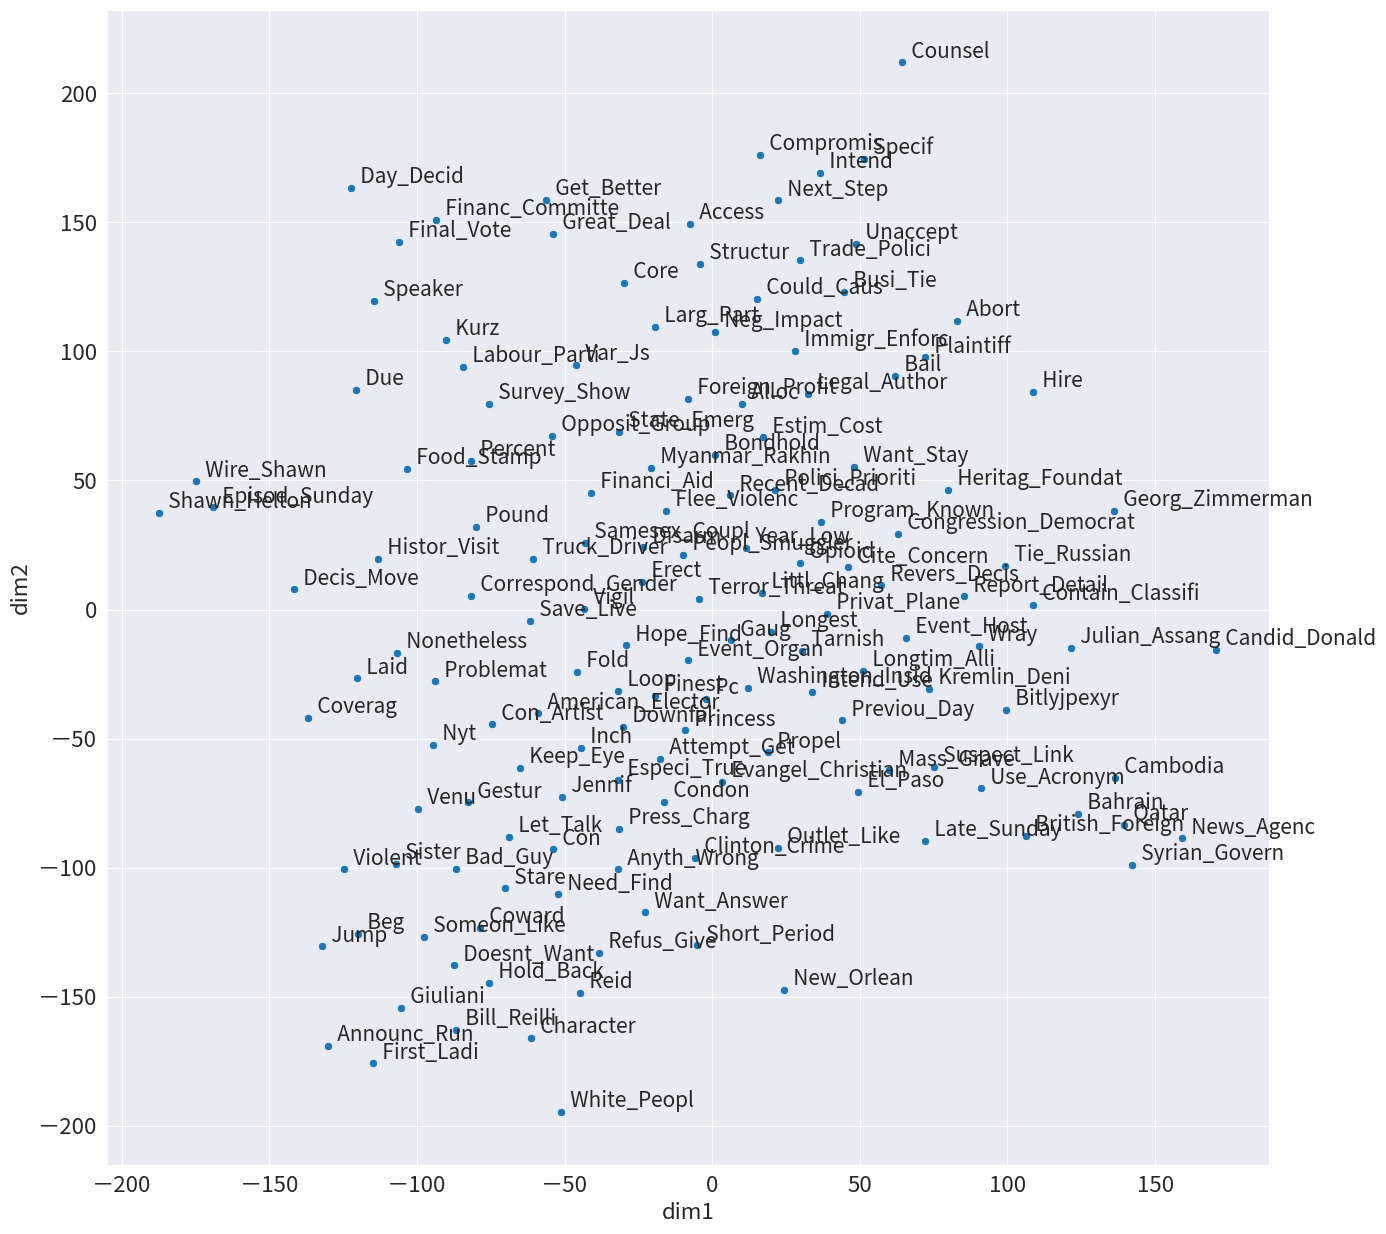

In [25]:
plotScatter(word_df)

3D 散狀圖

In [26]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(150, 3)


將字分群

In [27]:
#!pip install scikit-learn-extra

In [28]:
#只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [29]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

<h3>3.2 Transformers Embeddings</h3>

In [30]:
#!pip install -U sentence-transformers

<h4>小模型，以BERT為範例</h4>

In [31]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with mean pooling.


0

In [32]:
bert_en.get_max_seq_length()

512

In [33]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

In [34]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with mean pooling.


0

In [35]:
# 示範句子
sentences = [
    "Trump's treatening the world under the tariff policy.",
    "The quick brown fox jumps over the lazy dog.",
    "川普正在藉由關稅政策威脅世界。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
1,Trump's treatening the world under the tariff ...,川普正在藉由關稅政策威脅世界。,0.564212
2,The quick brown fox jumps over the lazy dog.,川普正在藉由關稅政策威脅世界。,0.366150
0,Trump's treatening the world under the tariff ...,The quick brown fox jumps over the lazy dog.,0.362455


<h3>四、使用embedding做NLP任務</h3>

<h4>4.1相似文件</h4>

In [36]:
# 使用英文預訓練 BERT 模型（適合英文句子）
model = SentenceTransformer('all-MiniLM-L6-v2')

# 將所有新聞內容轉換為向量
corpus_embeddings = model.encode(df['content'].tolist(), convert_to_tensor=True, batch_size=32)

# 任選一篇新聞作為查詢對象（你可自行更換 query_num 數值）
query_num = 10
query_embedding = model.encode(df['content'][query_num], convert_to_tensor=True)

# 計算與其他新聞的 cosine similarity
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

# 取相似度前五高的文章
top_k = 5
top_results = torch.topk(cos_scores, k=top_k)

# 顯示結果
print("\n\n======================")
print("查詢新聞標題:\n", df['title'][query_num])
print("\n最相似的新聞:")

for score, idx in zip(top_results[0], top_results[1]):
    print(f"{df['title'][idx.item()]} (Score: {score:.4f})")

print("======================\n\n")




查詢新聞標題:
 Jones certified U.S. Senate winner despite Moore challenge

最相似的新聞:
Jones certified U.S. Senate winner despite Moore challenge (Score: 1.0000)
Alabama to certify Democrat Jones winner of Senate election (Score: 0.9049)
Trump urges Moore to concede Alabama Senate race (Score: 0.9037)
Alabama Senate race winner urges Republican rival to 'move on' (Score: 0.8801)
Democrat wins U.S. Senate seat in Alabama in setback for Trump (Score: 0.8756)




<h4>4.2分類任務</h4>

轉成向量（用 title+text 合併的 content 欄位）

In [37]:
corpus = df["content"].tolist()
embeddings = model.encode(corpus, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

建立分類器（以 sklearn的邏輯回歸 ）

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, df["label"], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4650
           1       0.95      0.95      0.95      4330

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



包成function

In [39]:
def predict_news_authenticity(title: str, content: str, model_embed, clf):
    """
    輸入新聞標題與內文，使用已訓練的嵌入模型與分類器預測真假。
    
    參數：
    - title: 新聞標題（字串）
    - content: 新聞內文（字串）
    - model_embed: SentenceTransformer 模型
    - clf: 訓練好的分類模型（如 LogisticRegression）

    輸出：
    - 預測結果（True/Fake）
    - True 機率
    - Fake 機率
    """
    full_text = f"{title.strip()} : {content.strip()}"
    embedding = model_embed.encode(full_text).reshape(1, -1)
    pred_label = clf.predict(embedding)[0]
    pred_prob = clf.predict_proba(embedding)[0]

    result = "True" if pred_label == 1 else "Fake"
    true_prob = round(pred_prob[1], 4)
    fake_prob = round(pred_prob[0], 4)

    print(f"預測結果：{result}")
    print(f"True 機率：{true_prob}")
    print(f"Fake 機率：{fake_prob}")
    
    return result, true_prob, fake_prob


# 5.BERT (Encoder-only-model)

- Token classification 
    NER
- Sequence classification
    Sentiment Classification
    Relation Extraction (RE)
- Text Clustering (BERTopic)
    Embedding model
    Clustering model
    使用Representation方法去微調主題表示


In [40]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# 載入資料集
fake_df = pd.read_csv('./raw_data/fake.csv')
true_df = pd.read_csv('./raw_data/true.csv')

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前 10000 筆
data = pd.concat([fake_df.iloc[:10000], true_df.iloc[:10000]], ignore_index=True)
data = data[data['text'].notna()].reset_index(drop=True)

# 檢查各類別數量
print(data['label'].value_counts())


[nltk_data] Downloading package stopwords to /Users/yolun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yolun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yolun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
1    10000
0    10000
Name: count, dtype: int64


## 需要做文本預處理嗎?

目的:
- 建立分類器來預測真假新聞 -> (TF-IDF + 分類模型需要乾淨的資料，有幫助)
- 分析NER 結果與語意分佈 -> (會破壞語意)
- 建立主題模型來探索語意主題（BERTopic -> (會破壞語意)

In [41]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))



## NER 預測新聞真假

In [43]:
from matplotlib.font_manager import fontManager
import matplotlib.pyplot as plt

fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [ ]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
import pandas as pd
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# 設定裝置：優先使用 Apple GPU (MPS)，否則用 CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f" 使用裝置：{device}")

# 載入 BERT 模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER").to(device)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple",
                        device=0 if device.type != "cpu" else -1)

# 分段函數（確保不超過 512 token）
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 初始化結果列表
ner_rows = []

# 逐篇文章處理，加雙層進度條
for idx, text in tqdm(data['text'].astype(str).items(), desc="🔍 處理文章進度"):
    try:
        chunks = split_text(text)
        all_ents = []
        with torch.no_grad():  # 加速推論用
            for chunk in tqdm(chunks, leave=False, desc=f"文章 {idx} 分段中"):
                all_ents.extend(ner_pipeline(chunk))
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f" 第 {idx} 筆資料錯誤: {e}")

# 轉為 DataFrame
ner_df = pd.DataFrame(ner_rows)
ner_df.head()


In [47]:
ner_df.head(10)


,index,entity,word,score
0,0,PER,Donald Trump,0.999043
1,0,MISC,Americans,0.998977
2,0,LOC,Country,0.512395
3,0,ORG,F,0.991836
4,0,ORG,##ake News Media,0.968910
5,0,PER,Angry Pants,0.864726
6,0,LOC,America,0.999604
7,0,ORG,Fake News Media,0.917654
8,0,LOC,America,0.999512
9,0,PER,Donald J. Trump,0.886407


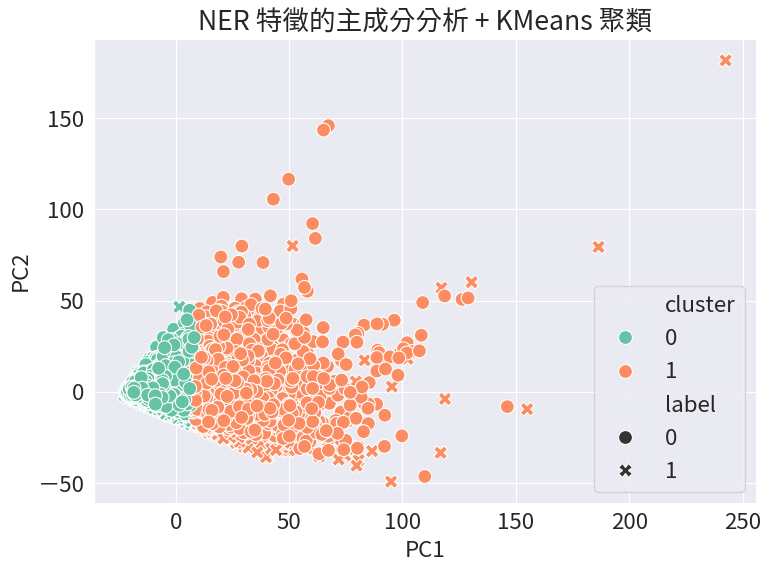

In [48]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 嘗試用 NER 提取出的'人名'、'組織'、'地名數量'作為詞彙特徵，再餵給 TF-IDF + 模型來預測這篇新聞是真/假

In [49]:
from sklearn.ensemble import RandomForestClassifier

# 聚合 ner_df 結果為特徵表（以 index = 文章編號為 key）
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)

# 合併回原資料集
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

# 建立特徵：人名、組織、地名數量
ner_pred_X = data_with_ner[['PER', 'ORG', 'LOC']]
ner_pred_y = data_with_ner['label']

# 建模
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(ner_pred_X, ner_pred_y, test_size=0.2, random_state=42)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

# Logistic Regression 結果
print("=== LogisticRegression 分類結果 ===")
print(classification_report(y_test, lr_pred))

# Random Forest 結果
print("=== RandomForestClassifier 分類結果 ===")
print(classification_report(y_test, rf_y_pred))

=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1981
           1       0.69      0.77      0.73      2019

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1981
           1       0.75      0.72      0.74      2019

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



### NER提取特徵預測結果尚可
小結:
預測真新聞:  LR      RF
precision   0.71    0.75
recall      0.62    0.74
f1          0.66    0.74

預測假新聞:
precision   0.66    0.74
recall      0.74    0.75
f1          0.70    0.74

NER 特徵對真假新聞辨識有一定程度作用，且用RandomForest的結果較優

## 使用情緒分析辨識真假新聞

In [50]:
# 載入情緒分析模型
model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# 因為這個語言也是BERT = 效果仰賴'自然語言語序與上下文' = 使用data['text']即可

# 切割文字 每段不超過 512 字
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 整合段落的情緒分數
def analyze_long_text(text):
    try:
        chunks = split_text(text)
        results = model(chunks)

        # 統計情緒
        pos_scores = [r['score'] for r in results if r['label'] == 'POSITIVE']
        neg_scores = [r['score'] for r in results if r['label'] == 'NEGATIVE']

        # 平均分數
        avg_pos = sum(pos_scores) / len(pos_scores) if pos_scores else 0
        avg_neg = sum(neg_scores) / len(neg_scores) if neg_scores else 0

        # 決定總體情續
        if avg_pos > avg_neg:
            return pd.Series(['POSITIVE', avg_pos])
        elif avg_neg > avg_pos:
            return pd.Series(['NEGATIVE', avg_neg])
        else:
            return pd.Series(['NEUTRAL', 0.5])
    except Exception:
        return pd.Series(['ERROR', 0.0])

# 執行分析
tqdm.pandas()
data[['sentiment_label', 'sentiment_score']] = data['text'].progress_apply(analyze_long_text)

data.head(10)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


  0%|          | 0/20000 [00:00<?, ?it/s]

,title,text,subject,date,label,tokens,clean_text,sentiment_label,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, wish, american, happy, new, ye...",donald trump wish american happy new year leav...,POSITIVE,0.995209
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,NEGATIVE,0.997675
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,"[friday, revealed, former, milwaukee, sheriff,...",friday revealed former milwaukee sheriff david...,NEGATIVE,0.995043
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,"[christmas, day, donald, trump, announced, wou...",christmas day donald trump announced would bac...,NEGATIVE,0.981710
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,"[pope, francis, used, annual, christmas, day, ...",pope francis used annual christmas day message...,POSITIVE,0.991508
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,"[number, case, cop, brutalizing, killing, peop...",number case cop brutalizing killing people col...,NEGATIVE,0.995830
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1,"[donald, trump, spent, good, portion, day, gol...",donald trump spent good portion day golf club ...,NEGATIVE,0.935587
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1,"[wake, yet, another, court, decision, derailed...",wake yet another court decision derailed donal...,NEGATIVE,0.934569
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1,"[many, people, raised, alarm, regarding, fact,...",many people raised alarm regarding fact donald...,POSITIVE,0.985874
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1,"[might, thought, get, break, watching, people,...",might thought get break watching people kiss d...,NEGATIVE,0.998032


In [51]:
sentiment_pred_X = data[['sentiment_score']]
sentiment_pred_y = data['label']

# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(sentiment_pred_X, sentiment_pred_y, test_size=0.2, random_state=42)

# 建立模型並訓練
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# 預測與評估
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 預測與評估
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44      1981
           1       0.54      0.73      0.62      2019

    accuracy                           0.55      4000
   macro avg       0.55      0.54      0.53      4000
weighted avg       0.55      0.55      0.53      4000

              precision    recall  f1-score   support

           0       0.51      0.52      0.51      1981
           1       0.52      0.51      0.51      2019

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



### 小結: 情緒預測真假新聞表現不好
小結:
預測真新聞:  LR      RF
precision   0.60    0.52
recall      0.37    0.50
f1          0.46    0.51

預測假新聞:
precision   0.54    0.52
recall      0.75    0.54
f1          0.63    0.53

整體分類效果偏弱，跟丟銅板差不多
模型偏好預測為假新聞（recall 高），但也多誤判

### 嘗試整合兩者

In [52]:
from sklearn.ensemble import RandomForestClassifier

combined_X = pd.concat([data_with_ner[['PER', 'ORG', 'LOC']], sentiment_pred_X], axis=1)
combined_y = data['label']
# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(combined_X, combined_y, test_size=0.2, random_state=42)

# Logistic Regression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估結果
print("=== Logistic Regression 分類結果 ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest 分類結果 ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1981
           1       0.70      0.78      0.74      2019

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1981
           1       0.77      0.74      0.75      2019

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



### 整合特徵後整體預測準確度上升

NER:
=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       201
           1       0.66      0.74      0.70       199

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       201
           1       0.74      0.75      0.75       199

    accuracy                           0.74       400
   macro avg       0.75      0.75      0.74       400
weighted avg       0.75      0.74      0.74       400



情緒分析:
              precision    recall  f1-score   support

           0       0.60      0.37      0.46       201
           1       0.54      0.75      0.63       199

    accuracy                           0.56       400
   macro avg       0.57      0.56      0.55       400
weighted avg       0.57      0.56      0.55       400

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       201
           1       0.52      0.54      0.53       199

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400




整合後:
=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       201
           1       0.69      0.75      0.72       199

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       201
           1       0.78      0.81      0.79       199

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

In [53]:
# 嘗試增加TF-IDF欄位(clean_text)

# 建立 TF-IDF 向量器（可自訂 ngram 範圍與維度限制）
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['clean_text'].fillna(''))

# 轉為 DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=data.index)

# 新增tf-idf欄位
ner_sentiment_df = pd.concat([ner_pred_X, sentiment_pred_X], axis=1)
combined_X_full = pd.concat([ner_sentiment_df, tfidf_df], axis=1)

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(combined_X_full, combined_y, test_size=0.2, random_state=42)

# Logistic
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估
print("=== Logistic Regression(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1981
           1       0.99      0.98      0.98      2019

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000

=== Random Forest(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1981
           1       0.99      1.00      1.00      2019

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



### 過擬合?

=== Logistic Regression(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       201
           1       0.99      0.96      0.98       199

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

=== Random Forest(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       0.99      1.00      1.00       199

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

- 修正: TfidfVectorizer max_features=1000 -> 200
- 修正: 資料各取1000筆 -> 10000筆

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_rf, combined_X_full, combined_y, cv=5, scoring='f1')
print(f"5-fold F1 scores: {scores}")
print(f"Mean F1: {scores.mean():.4f}")

5-fold F1 scores: [0.99428003 0.99825131 0.99825044 0.99824956 0.9867068 ]
Mean F1: 0.9951


### Topic model: BERTopic 主題詞來源使用c-TF-IDF頻率導向，表現方式偏向詞頻高的詞

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# 真假新聞進行主題建模
docs = data['text'].astype(str).tolist()

# 模型可換成 'all-MiniLM-L6-v2', 'microsoft/Phi-4-mini-instruct' 等
embedding_model = 'all-MiniLM-L6-v2'

# 可調整 測試用2000筆
# min_cluster_size 群集最少需要包含n個點，否則會被視為雜訊（noise）
# min_samples 包含至少n篇文章的主題才會被承認為主題
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=30) # Clustering layer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [56]:
# 建立一個儲存所有主題關鍵詞與 TF-IDF 分數的清單
all_topics = []

# 把主題總數拿出來（排除 -1 是未分類主題）
valid_topics = [topic for topic in topic_model.get_topic_info().Topic if topic != -1]

# 對每個主題取得詞與 c-TF-IDF 分數
for topic_id in valid_topics:
    topic_words = topic_model.get_topic(topic_id)
    for word, score in topic_words:
        all_topics.append({
            "Topic": topic_id,
            "Word": word,
            "C-TF-IDF": score
        })

# 轉換成 DataFrame 並排序
topic_tfidf_df = pd.DataFrame(all_topics)
topic_tfidf_df = topic_tfidf_df.sort_values(by=["Topic", "C-TF-IDF"], ascending=[True, False])

# 顯示前幾列
topic_tfidf_df.head(20)

,Topic,Word,C-TF-IDF
0,0,gun,0.009428
1,0,police,0.008096
2,0,black,0.007608
3,0,people,0.006337
4,0,white,0.005360
5,0,racist,0.004538
6,0,guns,0.004198
7,0,trump,0.004052
8,0,violence,0.004048
9,0,video,0.003925


In [57]:

# 列出文章的BERTopic資訊
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Donald Trump just couldn t wish all Americans ...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, donald trump,...",[CLEVELAND (Reuters) - On the floor and corrid...,trump - said - president - donald - donald tru...,0.000000,False
1,House Intelligence Committee Chairman Devin Nu...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, donald trump,...",[CLEVELAND (Reuters) - On the floor and corrid...,trump - said - president - donald - donald tru...,0.000000,False
2,"On Friday, it was revealed that former Milwauk...",0,0_gun_police_black_people,"[gun, police, black, people, white, racist, gu...",[While it may not come as much of a surprise t...,gun - police - black - people - white - racist...,0.875849,False
3,"On Christmas day, Donald Trump announced that ...",78,78_golf_golfing_trump_golf course,"[golf, golfing, trump, golf course, weekend, c...",[Donald Trump repeatedly attacked former Presi...,golf - golfing - trump - golf course - weekend...,0.498844,False
4,Pope Francis used his annual Christmas Day mes...,114,114_pope_francis_pope francis_vatican,"[pope, francis, pope francis, vatican, catholi...",[Pope Francis is now the anti-Christ in the ey...,pope - francis - pope francis - vatican - cath...,1.000000,False
...,...,...,...,...,...,...,...,...
19995,WASHINGTON (Reuters) - U.S. President Barack O...,11,11_clinton_fbi_email_emails,"[clinton, fbi, email, emails, comey, server, c...",[WASHINGTON/NEW YORK (Reuters) - The FBI is in...,clinton - fbi - email - emails - comey - serve...,0.707308,False
19996,LONDON (Reuters) - Planned changes that Presid...,3,3_tax_percent_tax reform_rate,"[tax, percent, tax reform, rate, reform, corpo...",[WASHINGTON (Reuters) - U.S. President Donald ...,tax - percent - tax reform - rate - reform - c...,0.317406,False
19997,WASHINGTON (Reuters) - Democratic front-runner...,12,12_sanders_bernie_clinton_bernie sanders,"[sanders, bernie, clinton, bernie sanders, dem...",[NEW YORK (Reuters) - U.S. Senator Bernie Sand...,sanders - bernie - clinton - bernie sanders - ...,0.419381,False
19998,(Reuters) - Headlines screaming “Deportations ...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, donald trump,...",[CLEVELAND (Reuters) - On the floor and corrid...,trump - said - president - donald - donald tru...,0.000000,False


In [58]:
def visualize_fake_news_ratio_by_topic(model, docs, labels, title="主題的假新聞比例"):
    doc_info = model.get_document_info(docs).copy()
    doc_info['label'] = labels

    # 計算比例與數量
    topic_fake_ratio = (
        doc_info[doc_info['Topic'] != -1]
        .groupby('Topic')['label']
        .mean()
        .reset_index()
        .rename(columns={'label': 'fake_news_ratio'})
    )
    topic_counts = (
        doc_info[doc_info['Topic'] != -1]['Topic']
        .value_counts()
        .rename_axis('Topic')
        .reset_index(name='count')
    )
    topic_stats = pd.merge(topic_fake_ratio, topic_counts, on='Topic')

    # 加上主題名稱
    topic_names = model.get_topic_info()[['Topic', 'Name']]
    topic_stats_named = topic_stats.merge(topic_names, on='Topic')

    # 過濾比例過低的主題
    topic_stats_named = topic_stats_named[topic_stats_named['fake_news_ratio'] >= 0.1]

    # 繪圖
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=topic_stats_named.sort_values(by='fake_news_ratio', ascending=False),
        x='fake_news_ratio', y='Name', palette='Reds'
    )
    plt.title(title)
    plt.xlabel('假新聞比例 (label=1)')
    plt.ylabel('主題代表詞')
    plt.grid(True, axis='x')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    plt.tight_layout()
    plt.show()

### representation topic model: 加上語意導向的KeyBERT, 表現方式是語意向量相似的詞 

In [59]:
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer

embedding_model_with_st = SentenceTransformer(embedding_model)  # 或其他你指定的模型
embeddings = embedding_model_with_st.encode(docs, show_progress_bar=True)

# 關鍵詞表示模型（非生成式）
keybert = KeyBERTInspired()

# 組裝 representation model
representation_model = {
    "KeyBERT": keybert
}

# 建立 BERTopic 模型（用 KeyBERT 調整主題表示）
representation_topic_model = BERTopic(
    embedding_model=embedding_model_with_st,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    top_n_words=30,
    verbose=True
)

# 訓練模型
topics, probs = representation_topic_model.fit_transform(docs, embeddings)

# 查看新的主題表示
representation_topic_model.get_topic_info()

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2025-05-11 22:15:51,454 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-11 22:15:54,153 - BERTopic - Dimensionality - Completed ✓
2025-05-11 22:15:54,154 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-11 22:15:54,386 - BERTopic - Cluster - Completed ✓
2025-05-11 22:15:54,390 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 22:16:15,546 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,6023,-1_trump_said_president_clinton,"[trump, said, president, clinton, donald, dona...","[trump, white house, donald trump, presidentia...",[More evidence is mounting against Hillary Cli...
1,0,1687,0_gun_police_black_people,"[gun, police, black, people, white, racist, gu...","[gun control, guns, gun, nra, shooting, shot, ...","[Where Congress isn t acting on gun reform, Pr..."
2,1,747,1_trump_twitter_realdonaldtrump_media,"[trump, twitter, realdonaldtrump, media, donal...","[trump realdonaldtrump, 2017 realdonaldtrump, ...",[The president-elect on Monday took issue with...
3,2,611,2_obamacare_insurance_healthcare_health,"[obamacare, insurance, healthcare, health, car...","[replace obamacare, repeal obamacare, obamacar...","[(Reuters) - After months of internal discord,..."
4,3,493,3_tax_percent_tax reform_rate,"[tax, percent, tax reform, rate, reform, corpo...","[tax cuts, tax cut, tax overhaul, republican t...",[WASHINGTON (Reuters) - U.S. President Donald ...
...,...,...,...,...,...,...
133,132,14,132_transgender_bathroom_transgender students_...,"[transgender, bathroom, transgender students, ...","[transgender rights, transgender students, tra...",[(Reuters) - Transgender students cheered the ...
134,133,13,133_japan_abe_japanese_tokyo,"[japan, abe, japanese, tokyo, hagerty, korea, ...","[japan relations, visit japan, japan defense, ...",[NEW YORK (Reuters) - Japan’s Prime Minister S...
135,134,13,134_turkey_turkish_ankara_erdogan,"[turkey, turkish, ankara, erdogan, kurdish, ra...","[turkish president, turkey, syrian kurdish, an...",[WASHINGTON (Reuters) - U.S. Secretary of Stat...
136,135,13,135_conway_kellyanne_kellyanne conway_cnn,"[conway, kellyanne, kellyanne conway, cnn, coo...","[kellyanne conway, conway lies, conway cnn, co...",[Vice President Mike Pence chose to appear on ...


In [60]:
# 視覺化主題分布：圓圈大小是主題的大小，圓圈的距離是主題之間的相似度
topic_model.visualize_topics()

In [61]:
representation_topic_model.visualize_topics()

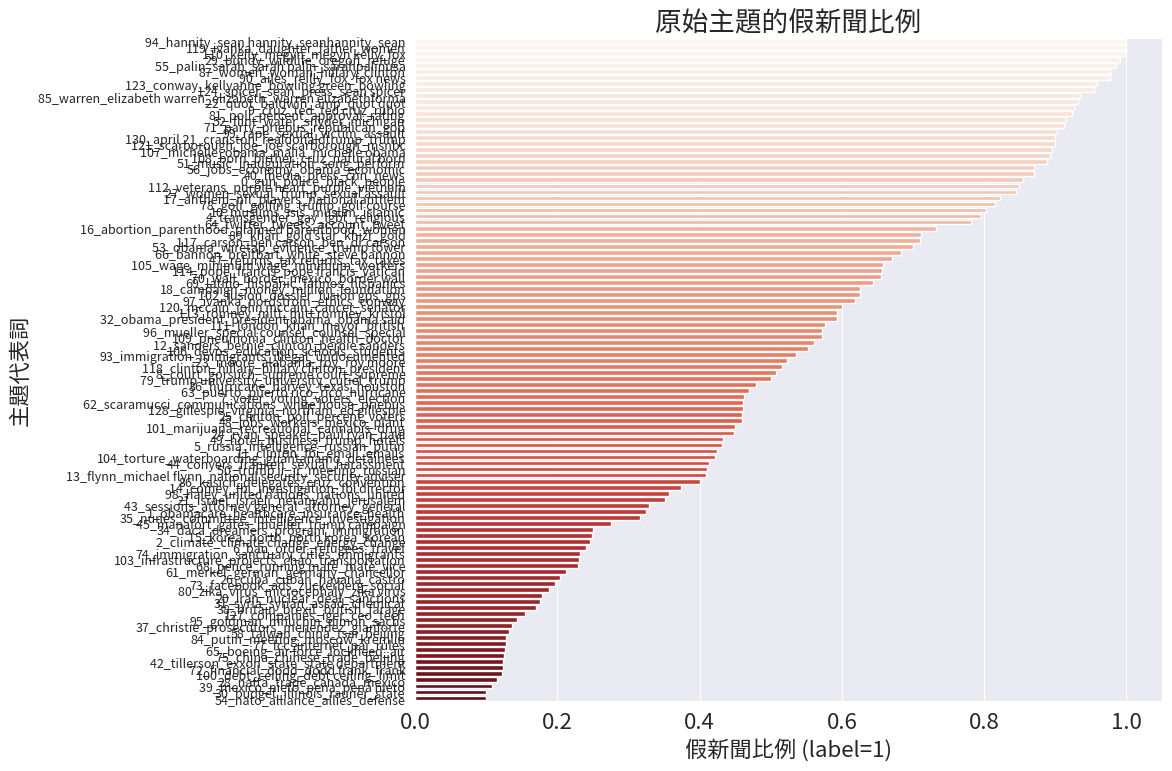

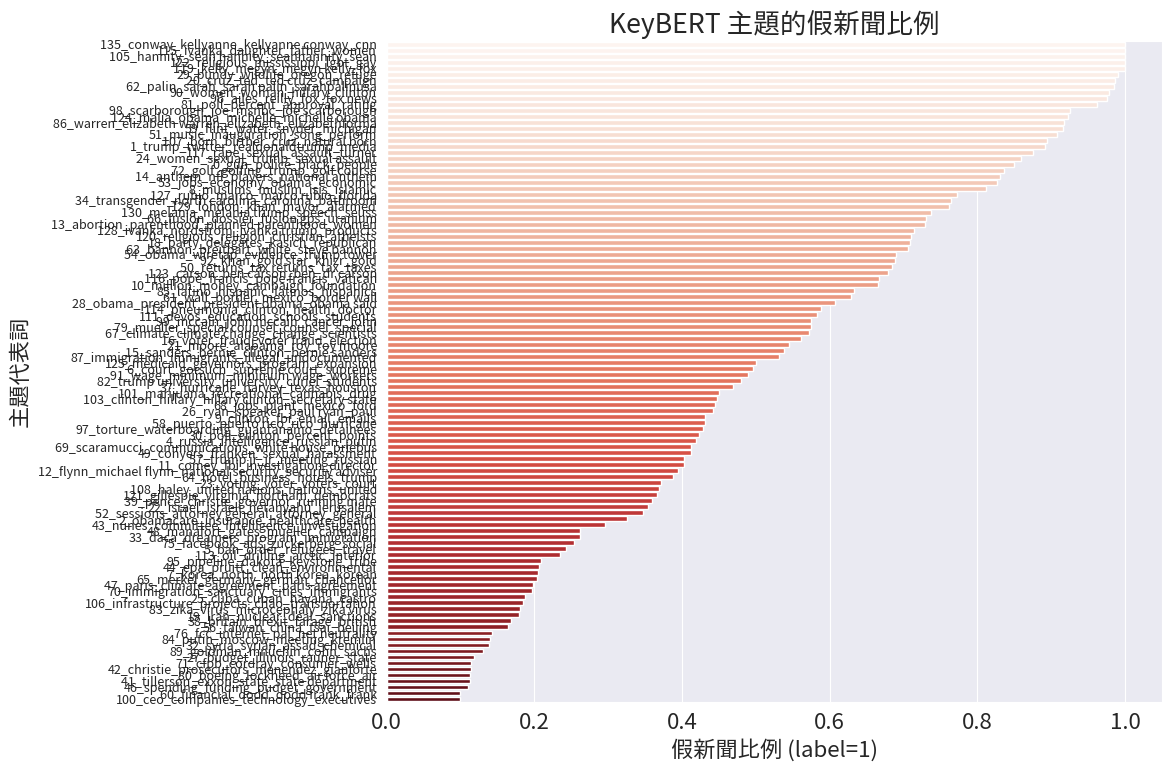

In [62]:
# 原始模型的主題
visualize_fake_news_ratio_by_topic(topic_model, docs, data['label'], title="原始主題的假新聞比例")

# 使用 KeyBERT 表示詞的模型主題
visualize_fake_news_ratio_by_topic(representation_topic_model, docs, data['label'], title="KeyBERT 主題的假新聞比例")